# **Notebook présentant une résolution par Random Forest du Challenge Data QRT 2024**

In [28]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import umap

# Méthode de sklearn:
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Récupération des données

In [3]:
train_home_team_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Train_Data/train_home_team_statistics_df.csv")
train_home_player_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Train_Data/train_home_player_statistics_df.csv")
train_away_player_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Train_Data/train_away_player_statistics_df.csv")
train_away_team_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Train_Data/train_away_team_statistics_df.csv")

train_scores = pd.read_csv("C:/Users/alqui/Downloads/Y_train_1rknArQ.csv", index_col=0)

train_home_team = train_home_team_statistics_df.iloc[:,3:]
train_away_team = train_away_team_statistics_df.iloc[:,3:]
train_home_player = train_home_player_statistics_df
train_away_player = train_away_player_statistics_df

train_home_team.columns = 'HOME_' + train_home_team.columns
train_away_team.columns = 'AWAY_' + train_away_team.columns
train_home_player.columns = 'HOME_' + train_home_player.columns
train_away_player.columns = 'AWAY_' + train_away_player.columns

train_team_data =  pd.concat([train_home_team,train_away_team],join='inner',axis=1)
train_player_data =  pd.concat([train_home_player,train_away_player],join='inner',axis=1)
train_data =  pd.concat([train_team_data,train_player_data],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [4]:
test_home_team_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Test_Data/test_home_team_statistics_df.csv")
test_home_player_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Test_Data/test_home_player_statistics_df.csv")
test_away_player_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Test_Data/test_away_player_statistics_df.csv")
test_away_team_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Test_Data/test_away_team_statistics_df.csv")

test_home_team = test_home_team_statistics_df.iloc[:,1:]
test_away_team = test_away_team_statistics_df.iloc[:,1:]
test_home_player = test_home_player_statistics_df
test_away_player = test_away_player_statistics_df

test_home_team.columns = 'HOME_' + test_home_team.columns
test_away_team.columns = 'AWAY_' + test_away_team.columns
test_home_player.columns = 'HOME_' + test_home_player.columns
test_away_player.columns = 'AWAY_' + test_away_player.columns

test_team_data =  pd.concat([test_home_team,test_away_team],join='inner',axis=1)
test_player_data =  pd.concat([test_home_player,test_away_player],join='inner',axis=1)
test_data =  pd.concat([test_team_data,test_player_data],join='inner',axis=1)

test_data = test_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [5]:
train_test_data = pd.concat([train_data,test_data], join = 'inner')
train_index = train_data.shape[0]

In [6]:
def trouver_colonnes_categorielles(df):
    colonnes_categorielles = []
    for nom_colonne in df.columns:
        if df[nom_colonne].dtype == 'object':
            colonnes_categorielles.append(nom_colonne)
    return colonnes_categorielles

colonnes_cat = trouver_colonnes_categorielles(train_test_data)
print("Colonnes catégorielles :", colonnes_cat)

for col in colonnes_cat:
    train_test_data = train_test_data.drop(col, axis = 1)

Colonnes catégorielles : ['HOME_POSITION', 'AWAY_POSITION']


## Filtration des valeurs NaN

In [7]:
colonnes_enlevees = []
for col in train_test_data.columns :
    if train_test_data[col].isna().sum() > 6000:
        colonnes_enlevees.append(col)
        train_test_data = train_test_data.drop(col, axis = 1)

print(colonnes_enlevees)

['HOME_TEAM_INJURIES_5_last_match_std', 'AWAY_TEAM_INJURIES_5_last_match_std', 'HOME_PLAYER_CAPTAIN_season_sum', 'HOME_PLAYER_PUNCHES_season_sum', 'HOME_PLAYER_LONG_BALLS_season_sum', 'HOME_PLAYER_LONG_BALLS_WON_season_sum', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_sum', 'HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average', 'HOME_PLAYER_CAPTAIN_season_average', 'HOME_PLAYER_PUNCHES_season_average', 'HOME_PLAYER_LONG_BALLS_season_average', 'HOME_PLAYER_LONG_BALLS_WON_season_average', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_average', 'HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std', 'HOME_PLAYER_CAPTAIN_season_std', 'HOME_PLAYER_PUNCHES_season_std', 'HOME_PLAYER_LONG_BALLS_season_std', 'HOME_PLAYER_LONG_BALLS_WON_season_std', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_std', 'HOME_PLAYER_CAPTAIN_5_last_match_sum', 'HOME_PLAYER_PUNCHES_5_last_match_sum', 'HOME_PLAYER_LONG_BALLS_5_last_match_sum', 'HOME_PLAYER_LONG_BALLS_WON_5_last_match_sum', 'HOME_PLAYER_SHOTS_OFF_TARGET_5_last_match_sum', 'HOME

In [8]:
imputer = SimpleImputer(strategy='mean')
train_data_imputed = pd.DataFrame(imputer.fit_transform(train_test_data), columns=train_test_data.columns)

In [9]:
scaler = StandardScaler().fit(train_data_imputed.iloc[:train_index,:])
df_scaled_train = pd.DataFrame(scaler.transform(train_data_imputed.iloc[:train_index,:]), columns = train_data_imputed.columns)

scaler2 = StandardScaler().fit(train_data_imputed.iloc[train_index:,:])
df_scaled_test = pd.DataFrame(scaler.transform(train_data_imputed.iloc[train_index:,:]), columns = train_data_imputed.columns)

In [10]:
data_test_final = df_scaled_test.iloc[test_data.index]

## Mise en place des datasets d'entraînements et de tests

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_scaled_train, train_scores, train_size=0.8, random_state=42)
X, y = df_scaled_train.copy(), train_scores

## Application du PCA

In [12]:
pca = PCA(n_components = 30)
pca.fit(X_train,y_train)

composantes_principales = pca.transform(X_train)
noms_colonnes = [f'Composante_{i+1}' for i in range(composantes_principales.shape[1])]
X_train_pca = pd.DataFrame(composantes_principales, columns = noms_colonnes)

comp = pca.transform(df_scaled_train)
df = pd.DataFrame(comp, columns = noms_colonnes)

In [13]:
print(pca.explained_variance_ratio_.sum())

0.5086330391354403


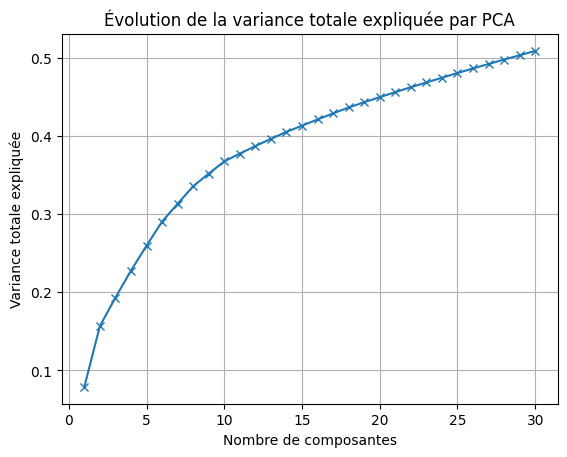

In [14]:
variance_expliquee = pca.explained_variance_ratio_
variance_cumulative = np.cumsum(variance_expliquee)

plt.plot(range(1, len(variance_cumulative) + 1), variance_cumulative, marker='x', linestyle='-')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance totale expliquée')
plt.title('Évolution de la variance totale expliquée par PCA')
plt.grid(True)
plt.show()

## Visualiation des données de test

In [15]:
x_test_pca = pca.transform(X_test)
noms_colonnes = [f'Composante_{i+1}' for i in range(X_train_pca.shape[1])]
X_test_pca = pd.DataFrame(x_test_pca, columns = noms_colonnes)


test_pca = pd.DataFrame(pca.transform(data_test_final), columns=noms_colonnes)

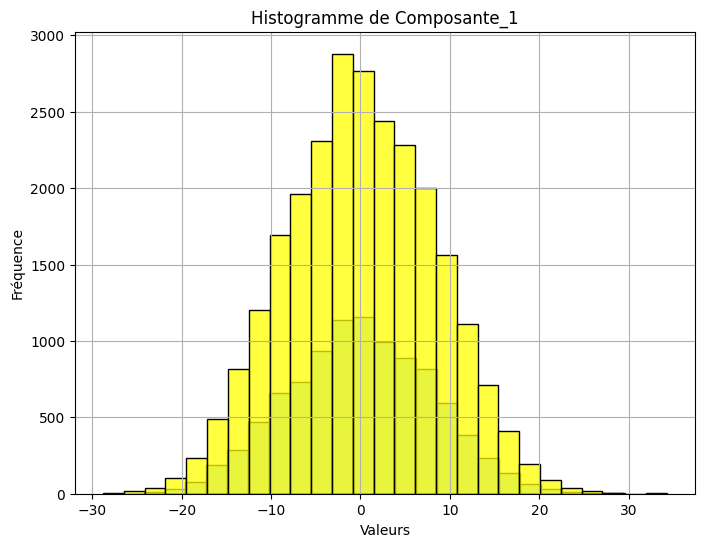

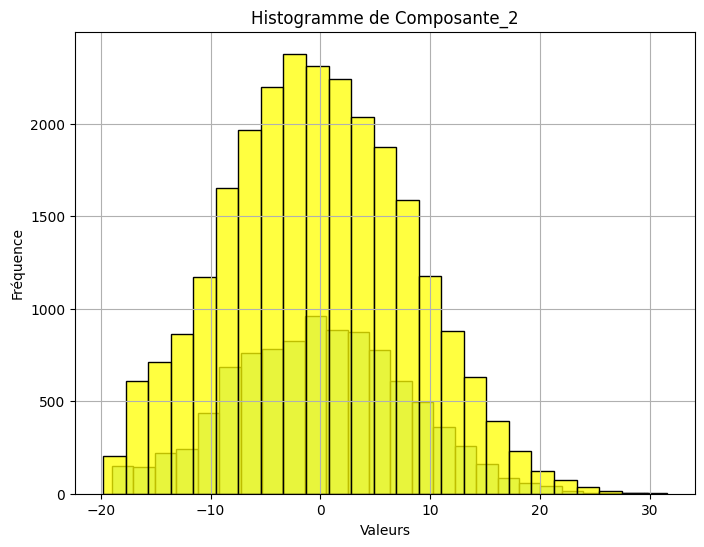

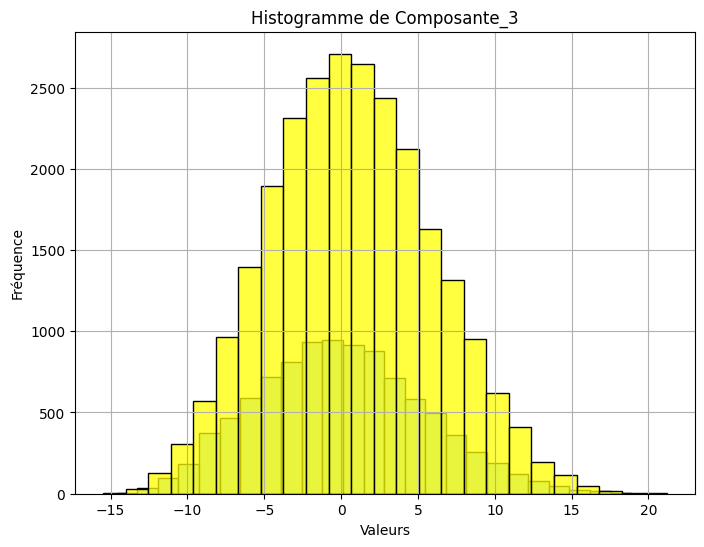

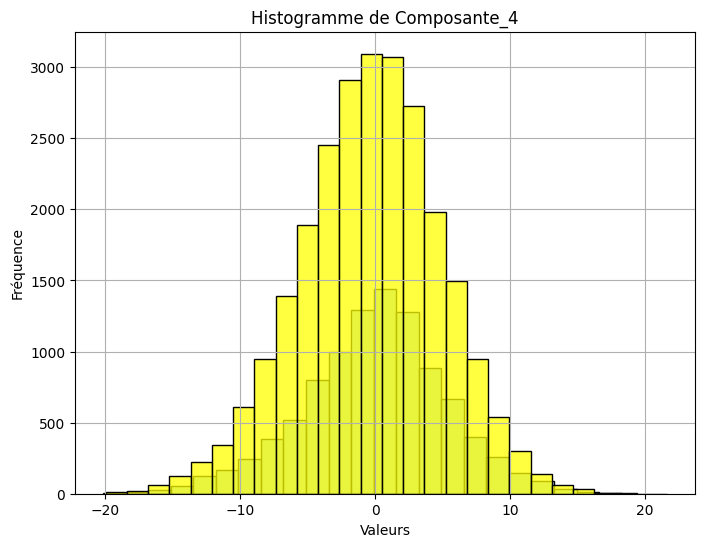

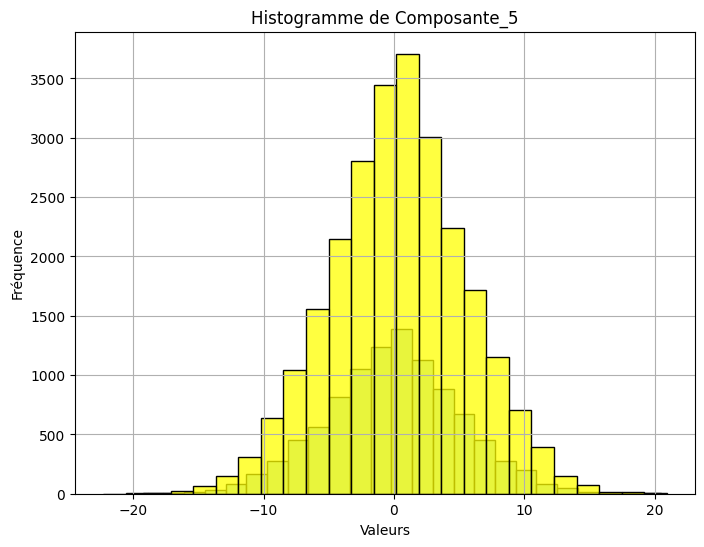

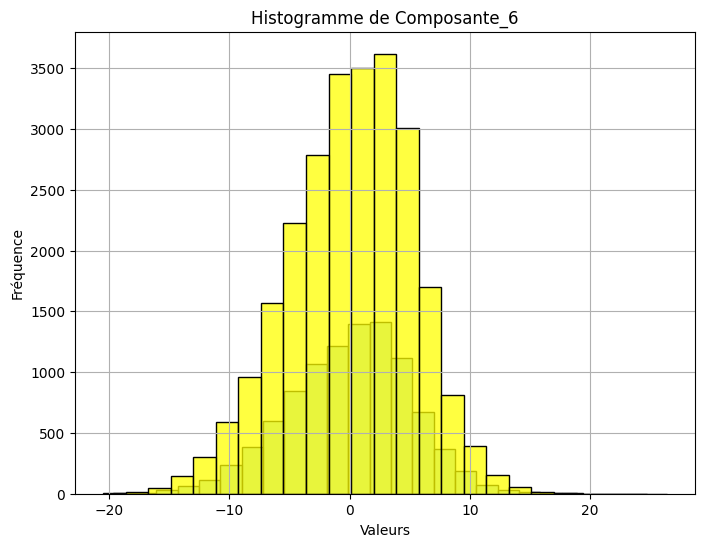

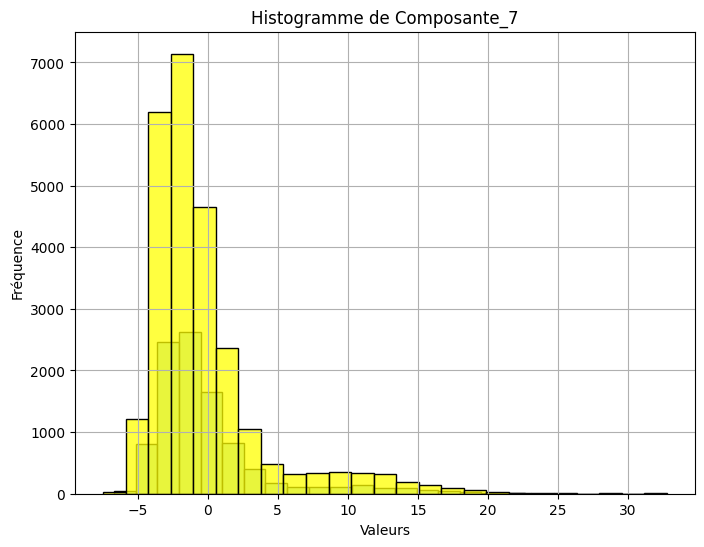

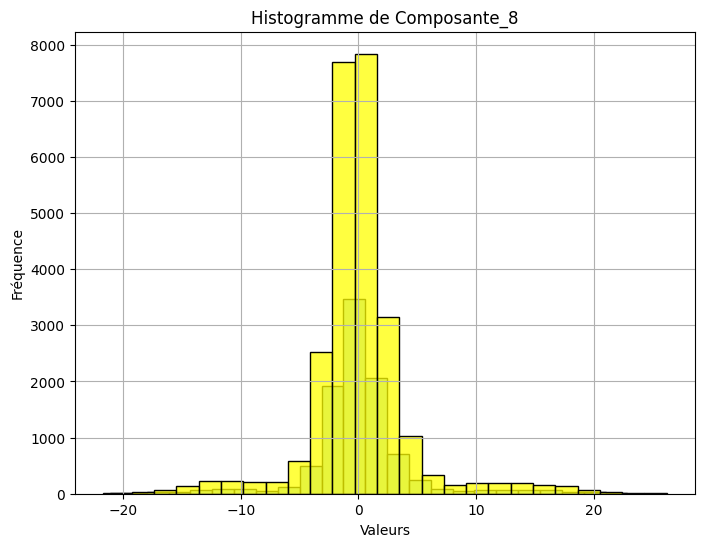

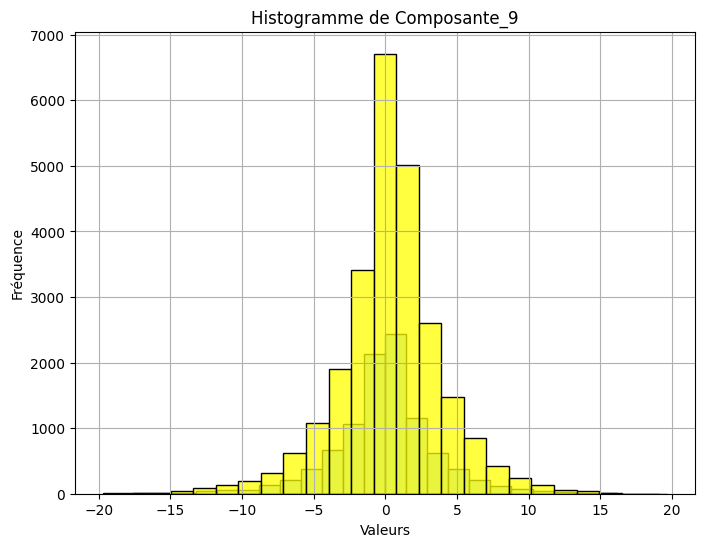

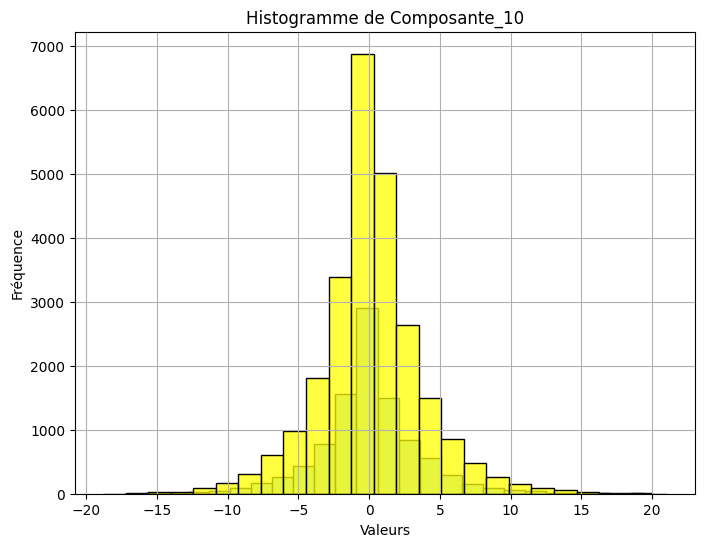

In [16]:
for colonne in test_pca.columns[:10]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=X_train_pca, x=colonne, bins=25, color='skyblue', edgecolor='black')
    sns.histplot(data=test_pca, x=colonne, bins=25, color='yellow', edgecolor='black')
    plt.title('Histogramme de ' + colonne)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

# Mise en place des modèles

In [17]:
y_train_indices = np.argmax(y_train, axis=1)
y_test_indices = np.argmax(y_test, axis=1)
y_indices = np.argmax(y, axis = 1)

In [18]:
def objective_pca(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    classifier = RandomForestClassifier(**params, random_state = 42)

    accuracy = cross_val_score(classifier, X_train_pca , y_train_indices, cv=5, scoring=make_scorer(accuracy_score)).mean()

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective_pca, n_trials=50)

[I 2024-04-16 17:58:23,157] A new study created in memory with name: no-name-804c7b69-1380-4014-8f41-9786889f911a
[I 2024-04-16 17:58:52,923] Trial 0 finished with value: 0.48150778117735465 and parameters: {'n_estimators': 173, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.48150778117735465.
[I 2024-04-16 17:59:20,150] Trial 1 finished with value: 0.4834374883870728 and parameters: {'n_estimators': 126, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.4834374883870728.
[I 2024-04-16 17:59:53,578] Trial 2 finished with value: 0.48547037000334453 and parameters: {'n_estimators': 137, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 0.48547037000334453.
[I 2024-04-16 18:00:15,645] Trial 3 finished with value: 0.43588750634840023 and parameters: {'n_estimators': 230, 'max_depth': 

In [21]:
best_params_pca = study.best_params
print("Best params:", best_params_pca)

best_rf_model = RandomForestClassifier(**best_params_pca, random_state = 42)
best_rf_model.fit(X_train_pca, y_train_indices)
print(accuracy_score(y_test_indices,best_rf_model.predict(X_test_pca)))

Best params: {'n_estimators': 224, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt'}
0.49410808614384394


# Application du modèle

In [22]:
results = []
res_pred = best_rf_model.predict(test_pca)
res_proba = best_rf_model.predict_proba(test_pca)

ID = train_index 

for res in res_pred:
    if res == 0 : 
        results.append([ID, 1, 0, 0])
    elif res == 1 : 
        results.append([ID, 0, 1, 0])
    elif res == 2 :
        results.append([ID, 0, 0, 1])
    ID += 1

results_test = pd.DataFrame(results, columns = ['ID', 'HOME_WINS', 'DRAW', 'AWAY_WINS'])

In [ ]:
results_test.to_csv("C:/Users/alqui/Downloads/XGBoost_PCA10.csv", index = False)

## Visualisation des résultats

C:\Users\alqui\AppData\Local\Temp\ipykernel_35392\2983230677.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(targets)


Text(0, 0.5, 'Count')

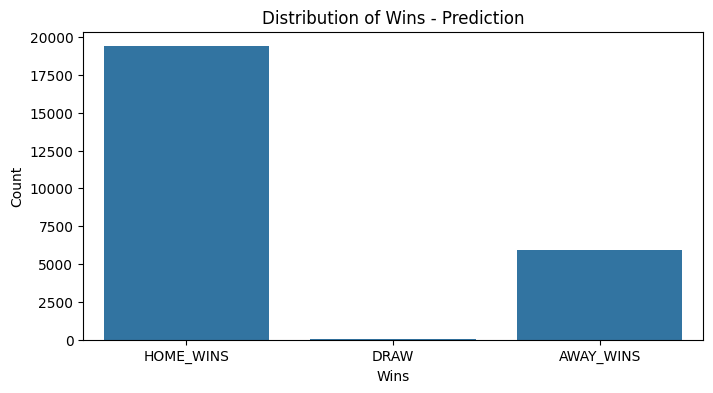

In [23]:
targets = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

targets_bin_pred = results_test[targets]
target_pred = targets_bin_pred@(np.arange(targets_bin_pred.shape[1]) + 1)
target_pred[targets_bin_pred.sum(axis=1)==2] = 3

plt.figure(figsize=(8, 4))
ax = sns.countplot(x=target_pred)
ax.set_xticklabels(targets) 

plt.title('Distribution of Wins - Prediction')
plt.xlabel('Wins')
plt.ylabel('Count')

In [24]:
results_test['DRAW'].sum()

34

## Visualisation des erreurs de prédiction

In [25]:
def evaluate_pred(y_pred, y_test , y_prob) :
    y_test_index = y_test.shape[0]
    evaluation_pred = {}
    prob = {'0_1':[], '0_2':[], '1_2':[], '1_0':[], '2_1':[],'2_0':[], '0':[], '1':[], '2':[]}
    ind = {'0_1':[], '0_2':[], '1_2':[], '1_0':[], '2_1':[],'2_0':[], '0':[], '1':[], '2':[]}
    evaluation_pred['0'] = 0
    evaluation_pred['1'] = 0
    evaluation_pred['2'] = 0
    evaluation_pred['0_1'] = 0     # prédiction de 1 au lieu de 0
    evaluation_pred['0_2'] = 0
    evaluation_pred['1_2'] = 0
    evaluation_pred['1_0'] = 0
    evaluation_pred['2_0'] = 0
    evaluation_pred['2_1'] = 0
    for index in range(y_test_index):
        if y_test[index] == y_pred[index]:
            if y_test[index] == 0 :
                evaluation_pred['0'] +=1
                prob['0'].append(y_prob[index][0])
                ind['0'].append(index)
            elif y_test[index] == 1 :
                evaluation_pred['1'] +=1
                prob['1'].append(y_prob[index][1])
                ind['1'].append(index)
            elif y_test[index] == 2 :
                evaluation_pred['2'] +=1
                prob['2'].append(y_prob[index][2])
                ind['2'].append(index)
        else : 
            if y_test[index] == 0 :
                if y_pred[index] == 1:
                    prob['0_1'].append(y_prob[index][1])
                    evaluation_pred['0_1'] +=1
                    ind['0_1'].append(index)
                if y_pred[index] == 2:
                    prob['0_2'].append(y_prob[index][2])
                    evaluation_pred['0_2'] +=1
                    ind['0_2'].append(index)
            elif y_test[index] == 1 :
                if y_pred[index] == 0:
                    prob['1_0'].append(y_prob[index][0])
                    evaluation_pred['1_0'] +=1
                    ind['1_0'].append(index)
                if y_pred[index] == 2:
                    prob['1_2'].append(y_prob[index][2])
                    ind['1_2'].append(index)
                    evaluation_pred['1_2'] +=1
            elif y_test[index] == 2 :
                if y_pred[index] == 1:
                    prob['2_1'].append(y_prob[index][1])
                    evaluation_pred['2_1'] +=1
                    ind['2_1'].append(index)
                if y_pred[index] == 0:
                    prob['2_0'].append(y_prob[index][0])
                    ind['2_0'].append(index)
                    evaluation_pred['2_0'] +=1

    return(evaluation_pred,prob,ind)

In [26]:
y_pred = best_rf_model.predict(X_test_pca)
y_prob = best_rf_model.predict_proba(X_test_pca)
eval_pred, prob_dict, ind_dict = evaluate_pred(y_pred,y_test_indices,y_prob)

print(len(prob_dict['1']),eval_pred['1'])

1 1


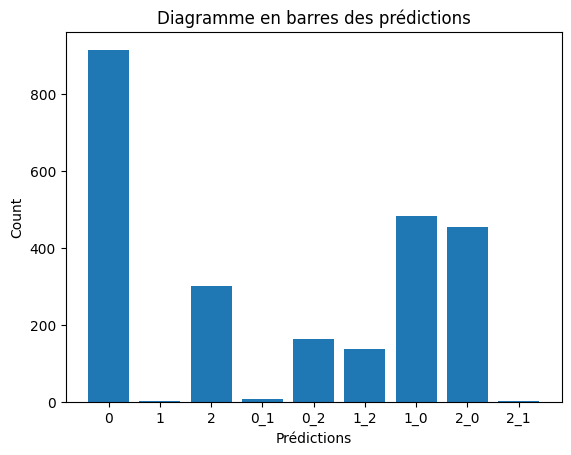

In [27]:
cles = list(eval_pred.keys())
valeurs = list(eval_pred.values())

plt.bar(cles, valeurs)

plt.xlabel('Prédictions')
plt.ylabel('Count')
plt.title('Diagramme en barres des prédictions')

plt.show()

In [ ]:
categories = list(prob_dict.keys())
L=['0_2','0_1','1','2_1']
for l in L:
    categories.remove(l)

for cat in categories:
    plt.figure(figsize=(8, 6))
    plt.hist(prob_dict[cat], bins = 25)
    plt.title('Histogramme des probas des erreurs ' + cat)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

In [ ]:
df_1_0 = X_test_pca.loc[ind_dict['1_0']]
df_0 = X_test_pca.loc[ind_dict['0']]

for colonne in X_test_pca.columns[:10]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_1_0, x=colonne, bins=25, color='skyblue', edgecolor='black')
    sns.histplot(data=df_0, x=colonne, bins=25, color='yellow', edgecolor='black')
    plt.title('Histogramme de ' + colonne)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

In [ ]:
df_1_2 = X_test_pca.loc[ind_dict['1_2']]
df_2 = X_test_pca.loc[ind_dict['2']]

for colonne in X_test_pca.columns[:10]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_2, x=colonne, bins=25, color='skyblue', edgecolor='black')
    sns.histplot(data=df_1_2, x=colonne, bins=25, color='yellow', edgecolor='black')
    plt.title('Histogramme de ' + colonne)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()